In [28]:
import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from astropy.cosmology import Planck15
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import astropy 
from ligo.skymap.io import fits
from ligo.skymap.postprocess import find_greedy_credible_levels

import os
from os import listdir
from os.path import isfile, join

import sys

H0GLOB=67 #69
Om0GLOB=0.319
Xi0Glob =1.
cosmoglob = Planck15
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)


In [29]:
def get_ename(fname, verbose=True):

        if len(fname.split('/')[-1].split('_')) <= 2:    #Same as before since certain names contain a "_"
            event_name = fname.split('/')[-1].split('_')[0]
        elif len(fname.split('/')[-1].split('_')) > 2:
            event_name = fname.split('/')[-1].split('_')[0]+'_'+fname.split('/')[-1].split('_')[1]
        else:
            raise ValueError('Could not set event name. Got fname= %s'%fname)
        if verbose:
            print('-- %s' %event_name)
        return event_name
    
def find_ra_dec(nside, pix):
        '''
        input:  pixel ra dec in degrees
        output: (ra, dec) of pixel center in degrees, with nside given by that of the skymap 
        '''
        theta, phi =find_theta_phi(nside,pix)
        ra, dec = ra_dec_from_th_phi(theta, phi)
        return ra, dec    
    
def ra_dec_from_th_phi(theta, phi):
        ra = np.rad2deg(phi)
        dec = np.rad2deg(0.5 * np.pi - theta)
        return ra, dec
    
def find_theta_phi(nside, pix):
        '''
        input:  pixel
        output: (theta, phi)of pixel center in rad, with nside given by that of the skymap 
        '''
        return hp.pix2ang(nside, pix, nest=True)
    
def _read_O3( fname, convert_nested=True):
        
        skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        event_name = get_ename(fname, verbose=True)
        print('Event: %s' %event_name)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            p_posterior = hp.reorder(skymap[0],n2r=True)
            mu = hp.reorder(skymap[1],n2r=True)
            sigma = hp.reorder(skymap[2],n2r=True)
            posteriorNorm = hp.reorder(skymap[3],n2r=True)
            print('convertito da nested a ring')
        else:
            p_posterior= skymap[0]
            mu= skymap[1]
            sigma = skymap[2]
            posteriorNorm= skymap[3]        
        npix = len(p_posterior)
        nside=hp.npix2nside(npix)
        theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
        #print('Theta={}, Phi={}'.format(theta, phi))
        #ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
        #print('Right Ascension={}, Declination={}'.format(ra, dec))
        #print(metadata)
        #dl=metadata['distmean']
        #std=metadata['diststd']
        #z=cosmoglob.H(0).value*dl/clight
        #sigz=cosmoglob.H(0).value*std/clight
        #print('dL={}Mpc, std={}Mpc'.format(dl,std))
        #print('z={}, delta_z={}'.format(z,sigz))
        #print('\n')
        head = None
def z_from_dL(dL_GW_val):
    '''
    Returns redshift for a given luminosity distance dL_GW_val (in Mpc)
    
    Input:
        - dL_GW_val luminosity dist in Mpc
        - H0
        - Xi0: float. Value of Xi_0
        - n: float. Value of n

    '''   
    from scipy.optimize import fsolve
    #print(cosmo.H0)
    func = lambda z : cosmoflag.luminosity_distance(z).value - dL_GW_val
    z = fsolve(func, 1)
    return z[0]

In [30]:
ra_dec_from_th_phi(np.pi/4,np.pi/4)

(45.0, 45.0)

In [31]:
#GWdata path
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)
#all_event=os.listdir()


  # Function to exploit, find how to localise an event and produce a proxy one. 
   def _read_O3(self, fname, convert_nested=True):
        
   skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        self.event_name = get_ename(fname, verbose=self.verbose)
        if self.verbose:
                print('\nEvent: %s' %self.event_name)
                #Raul: prints for control
                print('Delta=%s. If delta=1, normal run '%delta)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            self.p_posterior = hp.reorder(skymap[0],n2r=True)
            self.mu = hp.reorder(skymap[1],n2r=True)
            self.sigma = hp.reorder(skymap[2],n2r=True)*delta
            self.posteriorNorm = hp.reorder(skymap[3],n2r=True)
        else:
            self.p_posterior= skymap[0]
            self.mu= skymap[1]
            self.sigma = skymap[2]*delta
            self.posteriorNorm= skymap[3]    

In [32]:
#Some files to look at 
filenames=['GW190814_PublicationSamples.fits',
           'GW190924_021846_PublicationSamples.fits',
           'GW190412_PublicationSamples.fits',
           'GW190915_235702_PublicationSamples.fits',
           'GW190708_232457_PublicationSamples.fits',
           'GW190421_213856_PublicationSamples.fits',
           'GW190527_092055_PublicationSamples.fits' 
           ]
########################## THIS GIVE US SOME INFO ######################################
#for name in filenames:
#    _read_O3(name)
########################################################################################
fname ='GW190814_PublicationSamples.fits'
skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)

In [33]:
p_posterior= skymap[0]
mu= skymap[1]
sigma = skymap[2]
posteriorNorm= skymap[3]        
npix = len(p_posterior)
nside=hp.npix2nside(npix)
theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
print('RA={},dec={},theta={},phi={}'.format(ra,dec,theta,phi))
#10 deg^2 =0.000 304 617 419 786 71 sr
radius_deg= np.sqrt(10/np.pi)
sigma_deg=radius_deg/2.8
circle_deg=6*sigma_deg

RA=12.7001953125,dec=-24.87076339473571,theta=2.004873035517517,phi=0.22166022384947515


In [37]:
my_theta,my_phi=hp.pix2ang(nside, np.argmax(p_posterior), nest=True)
vec = hp.ang2vec(my_theta, my_phi)
my_maxpix=hp.ang2pix(nside, my_theta, my_phi,nest=True)
maxpix=np.argmax(p_posterior)
print(maxpix,my_maxpix)

4266225 4266225


In [38]:
print(vec)

[ 0.88506156  0.19946041 -0.42057292]


In [ ]:
hp.mollview(p_posterior, title=fname,nest=True)

In [39]:
credible_levels = find_greedy_credible_levels(p_posterior)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))

Ligo area_deg 99% is 48.40035970411115
Ligo area_deg 90% is 18.838208146028766 


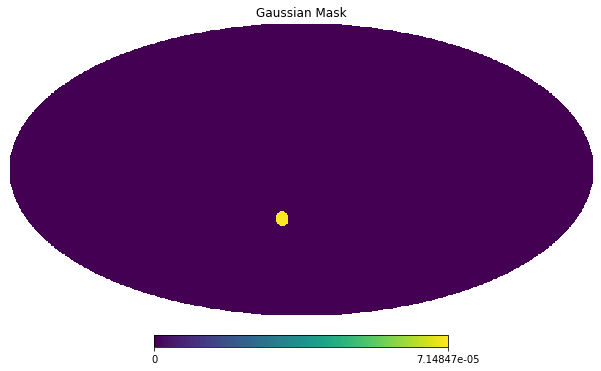

In [40]:
vec = hp.ang2vec(my_theta, my_phi)
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(circle_deg), nest=True)
ipix_90 = hp.query_disc(nside=nside, vec=vec, radius=np.radians(radius_deg), nest=True)
m =np.zeros(len(p_posterior))
m[ipix_disc] = 1/len(ipix_disc)
hp.mollview(m, title="Gaussian Mask",nest=True)

In [36]:
Mock_Area_deg=len(ipix_disc) * hp.nside2pixarea(nside, degrees=True)
Mock_Area_90_deg=len(ipix_90) *hp.nside2pixarea(nside, degrees=True)
print('99.9999% area is {} squared deg\n90% area is {} squared deg'.format(Mock_Area_deg,Mock_Area_90_deg))

99.9999% area is 45.882478768477654 squared deg
90% area is 9.986282981692243 squared deg


In [ ]:
'''
https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html(for ref on skymap)

Now we need to rescale the probability. We set the prob=0 ouside the circle
We assume that the renormalization is constant.
We crate a mask with our circle. Outside the mask p_posterior=0, the renormalization
constan alpha, is therefore 1/sum(p_posterior()). This ensure unitarity. 

If this works, than we will use a 2D Gaussian distribution for the probability

'''


In [ ]:
#saved_prob=np.zeros(len(p_posterior))
#saved_prob[ipix_disc]=p_posterior[ipix_disc]
#prob_to_write=np.zeros(len(p_posterior))
#alpha=1/np.sum(saved_prob)
#prob_to_write[ipix_disc]=alpha*saved_prob[ipix_disc]

In [ ]:
#print(np.sum(prob_to_write))

In [ ]:
#hp.mollview(prob_to_write, title="Mollview image NESTED",nest=True)

In [ ]:
#my_sky_tosave=(prob_to_write,skymap[1],sigma,posteriorNorm)
#my_sky_tosave=np.array([prob_to_write,mu,sigma,posteriorNorm])
#dat=Table([prob_to_write,mu,sigma,posteriorNorm],
#          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
#dat.write('Amap.fits',format='fits',overwrite=True)
#fits.write_sky_map('Amap.fits',dat, nest=True)

In [ ]:
#check result

In [ ]:
#my_data,my_meta=fits.read_sky_map("Amap.fits",nest=None, distances=True)
#print(my_meta)

In [ ]:
#hp.mollview(my_data[0], title="Mollview image NESTED",nest=True)

In [ ]:
#print(my_meta)

In [ ]:
#_read_O3('Amap.fits')

In [49]:
sigma_theta=np.radians(sigma_deg)*2
sigma_phi=np.radians(sigma_deg)*2
my_theta=np.pi/4
my_phi=np.pi/4
#print(my_theta,my_phi)
vec = hp.ang2vec(my_theta, my_phi)
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(circle_deg), nest=True)
def uncorr_gauss(x,y,mux=my_theta,muy=my_phi,sigx=sigma_theta,sigy=sigma_phi):
    #correlation is 0 so is a multiplication of two gaussians
    xfactor=((x-mux)/sigx)**2
    yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    ret=np.exp(-(1/2)*(xfactor+yfactor))#/norm
    return ret

In [50]:
gaussmap =np.zeros(len(p_posterior))
mod_mu=np.zeros(len(p_posterior))
zref=1
dlref=(1+zref)*cosmoflag.comoving_distance(zref).value
print(dlref)
peakdl=mu[np.argmax(p_posterior)]
#diff=abs(dlref-peakdl)

6827.38271411155


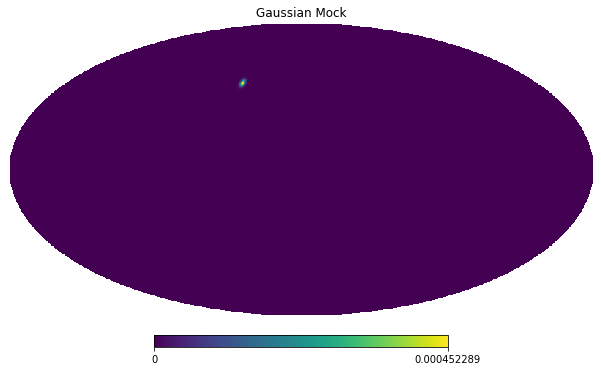

In [51]:
for i in ipix_disc:
    theta,phi=hp.pix2ang(nside,i, nest=True)
    gaussmap[i]=uncorr_gauss(theta,phi)*hp.nside2pixarea(nside, degrees=True)
    mod_mu[i]=dlref#mu[i]+diff
#gaussmap[ipix_disc] = 1/len(ipix_disc)
gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
hp.mollview(gaussmap, title="Gaussian Mock",nest=True)

In [ ]:
#print(gaussmap[gaussmap>0])

In [47]:
print(np.max(p_posterior))
print(np.max(gaussmap))
print(np.max(mod_mu))

0.0006588459413258549
0.0004560906711889105
6827.38271411155


In [ ]:
np.sum(gaussmap)

In [48]:
temp_theta,temp_phi=find_theta_phi(nside,np.argmax(gaussmap))
temp_ra, temp_dec=find_ra_dec(nside,np.argmax(gaussmap))
print('GW220810 location: theta={}, phi={}, RA={}, DEC={}'.format(temp_theta,temp_phi,temp_ra,temp_dec))

GW220810 location: theta=0.7846419767535534, phi=0.7853981633974483, RA=45.0, DEC=45.04332630321934


In [52]:
#my_sky_tosave=(gaussmap,mu,sigma,posteriorNorm)
my_sky_tosave=np.array([gaussmap,mod_mu,sigma,posteriorNorm])
dat=Table([gaussmap,mod_mu,sigma,posteriorNorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
#dat.write('Amap.fits',format='fits',overwrite=True)
fits.write_sky_map('GW220810_PublicationSamples.fits',dat, nest=True)

In [53]:
my_data,my_meta=fits.read_sky_map("GW220810_PublicationSamples.fits",nest=None, distances=True)

In [42]:
my_prob=my_data[0]
my_mu=my_data[1]
my_sigma=my_data[2]
npix = len(my_prob)
nside=hp.npix2nside(npix)
#my_mu[np.isinf(my_mu)]=0

In [43]:
my_theta,my_phi=find_theta_phi(nside,np.argmax(my_prob))
my_ra, my_dec=find_ra_dec(nside,np.argmax(my_prob))
print('GW220810 location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))


GW220810 location: theta=0.7846419767535534, phi=0.7853981633974483, RA=45.0, DEC=45.04332630321934


In [18]:
if(np.isnan(my_prob).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
if(np.isnan(my_mu).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
    
if(np.isinf(my_prob).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")
if(np.isinf(my_mu).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")

The Array does not contain NaN values
The Array does not contain NaN values
The Array does not contain inf values
The Array does not contain inf values


In [19]:
credible_levels = find_greedy_credible_levels(my_prob)
#Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
#Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
#print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))


In [27]:

mu_avr=np.average(my_mu,weights=my_prob)
print('average luminosity distance={} Mpc'.format(mu_avr))
z_gw=z_from_dL(mu_avr)
print('redshift={}, in flagship cosmology'.format(z_gw))
comov=mu_avr/(1+z_gw)
print('comoving distance={}'.format(comov))

average luminosity distance=6827.38271411155 Mpc
redshift=1.0, in flagship cosmology
comoving distance=3413.691357055775


In [ ]:
np.sum(my_mu[0:3]*my_prob[0:3])

In [ ]:
len(my_mu)==len(my_prob)

# Noise

In [ ]:
noise_data_path='/home/rciancarella/DarkSirensStat/data/GW/detectors/'
os.chdir(noise_data_path)

In [ ]:
freq=np.loadtxt('ET-0000A-18_ETDSensitivityCurveTxtFile.txt',usecols=0)
temp_noise=np.loadtxt('ET-0000A-18_ETDSensitivityCurveTxtFile.txt',usecols=1)
temp_noise=temp_noise/100

In [ ]:
to_save=np.column_stack([freq,temp_noise])
#print(to_save)
np.savetxt('O3-L1-C01_CLEAN_SUB60HZ-1240573680.0_sensitivity_strain_asd.txt',to_save)
np.savetxt('O3-H1-C01_CLEAN_SUB60HZ-1251752040.0_sensitivity_strain_asd.txt',to_save)

In [ ]:
explore=np.loadtxt('ET-0000A-18_ETDSensitivityCurveTxtFile.txt',usecols=(0,3))

In [ ]:
print(explore)